In [4]:
from network import SFGAT_LSTM_GAN
from network import SFGAT_LSTM
from network import SFGAT_LSTM_LONG
from network import SFGAT
from network import SFGAT_POI_SVI
from network import SFGAT_POI_SVI_LONG
from dataset import NYCTrafficCountDataset_sub
from dataset import NYCTrafficCountDataset_long
from dataset import NYCTrafficCountDataset_short
from dataset import NYCTrafficCountDataset_short_12
from dataset import NYCTrafficCountDataset_short_6
from network import SFGAT_LONG
from dataset import NYCTrafficCountDataset_test_short
from dataset import NYCTrafficCountDataset_test_long
from network import *
from torch_geometric.data import DataLoader
from tqdm import tqdm
from utils import MAPE
import torch
import os
import numpy as np
import pandas as pd
from train import getDatasetLst
import matplotlib.pyplot as plt

In [5]:
def getDatasetLst(trafficPth, adjFolder):
    trafficLst = []
    adjLst = []
    dateLst = os.listdir(trafficPth)
    for date in dateLst:
        datePth = os.path.join(trafficPth, date)
        adjPth = os.path.join(adjFolder, date)
        trafficLst.append(pd.read_csv(datePth))
        adjLst.append(pd.read_csv(adjPth))
    return dateLst, trafficLst, adjLst

In [6]:
def test_long(input_length, best_path, netName):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)

    net = netName(input_length).to(device)
    net.load_state_dict(torch.load(best_path))
    net.eval()

    test_trafficPath = r"/home/huihai/Huihai/StreetFunction/Data_subGraph/test/data"
    test_adjPath = r"/home/huihai/Huihai/StreetFunction/Data_subGraph/test/adj"
    xPath = r"/home/huihai/Huihai/StreetFunction/X"
    scenePath = r"/home/huihai/Huihai/StreetFunction/X/scene.csv"
    columnLst = ['SVIID',
                'StreetWidt', 'Length',  
                'Commercial', 'CulturalFa', 'EducationF','Government', 'HealthServ', 
                'Miscellane', 'PublicSafe', 'Recreation', 'ReligiousI', 'Residentia', 
                'SocialServ', 'Transporta', 'Water',
                'Avg_B01001', 'Avg_B010_1', 'Avg_B010_2', 'Avg_B010_3', 'Avg_B02001',
                'Avg_B020_1', 'Avg_B020_2', 'Avg_B08006', 'Avg_B080_1', 'Avg_B080_2',
                'Avg_B08013', 'Avg_B08124', 'Avg_B15003', 'Avg_B19001', 'Avg_B19013',
                'Avg_B23013', 'Avg_B24011', 'Avg_B240_1', 'Avg_B240_2', 'Avg_B240_3',
                'Avg_B240_4', 'Avg_B240_5', 'Avg_B240_6', 'Avg_B240_7', 'Avg_B240_8',
                'Avg_B240_9', 'Avg_B24_10', 'Avg_B24_11', 'Avg_B24_12', 'Avg_B24_13',
                'Avg_B24_14', 'Avg_B24_15', 'Avg_B24_16', 'Avg_B24_17', 'Avg_B24_18',
                'Avg_B24_20', 'Avg_B24_21', 'Avg_B24_22', 'Avg_B24_23', 'Avg_B24_24']
    xLst = []
    xLst.append(pd.read_csv(os.path.join(xPath, "Divided_2016.csv"))[columnLst])
    xLst.append(pd.read_csv(os.path.join(xPath, "Divided_2017.csv"))[columnLst])
    xLst.append(pd.read_csv(os.path.join(xPath, "Divided_2018.csv"))[columnLst])
    xLst.append(pd.read_csv(os.path.join(xPath, "Divided_2019.csv"))[columnLst])
    # print(os.listdir(test_trafficPath))

    testDateLst, testTrafficLst, testAdjLst = getDatasetLst(test_trafficPath, test_adjPath)
    test_dataset = NYCTrafficCountDataset_long(testTrafficLst, xLst, testAdjLst, testDateLst, scenePath, input_length)
    test_dataloader = DataLoader(test_dataset, 
                                    batch_size=1, 
                                    shuffle=False, 
                                    num_workers=5)

    loss1 = torch.nn.L1Loss()
    loss2 = torch.nn.MSELoss()
    loss3 = MAPE

    loss_MAE = []
    loss_RMSE = []
    loss_MAPE = []

    for batch in test_dataloader:
        with torch.no_grad():
            batch.to(device)
            mask = batch.y[:, -3]
            mask = mask == 1

            out_val = net(batch)
            out_val = out_val[mask]

            y = batch.y[:, 0:4]
            y = y[mask]

            minv = batch.y[:, -2][mask]
            maxv = batch.y[:, -1][mask]    
            minv = minv.reshape((minv.shape[0], 1))
            maxv = maxv.reshape((maxv.shape[0], 1))               

            out_val = out_val * (maxv - minv) + minv

            # mask_2 = y>0
            # # print(mask_2.shape)
            # y = y[mask_2]
            # out_val = out_val[mask_2]

            l_MAE = loss1(out_val, y)
            l_MAE.detach().tolist()
            loss_MAE.append(l_MAE)        # if i%5 == 0:
        #     model_path = os.path.join(normal_path, str(i) + ".pt")
        #     torch.save(model.state_dict(), model_path)MAE)

            l_RMSE = loss2(out_val, y)
            l_RMSE = torch.sqrt(l_RMSE)
            l_RMSE = l_RMSE.detach().tolist()
            loss_RMSE.append(l_RMSE)

            mask_3 = y>10
            # print(mask_2.shape)
            y = y[mask_3]
            out_val = out_val[mask_3]

            l_MAPE = loss3(out_val, y)
            l_MAPE = l_MAPE.detach().tolist()
            loss_MAPE.append(l_MAPE)

    print(sum(loss_MAE)/len(loss_MAE))
    print(sum(loss_RMSE)/len(loss_RMSE))
    print(sum(loss_MAPE)/len(loss_MAPE))

In [35]:
def test_short(input_length, best_path, model_name):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)

    net = model_name(input_length).to(device)
    net.load_state_dict(torch.load(best_path))
    net.eval()

    test_trafficPath = r"/home/huihai/Huihai/StreetFunction/Data_subGraph/test/data"
    test_adjPath = r"/home/huihai/Huihai/StreetFunction/Data_subGraph/test/adj"
    xPath = r"/home/huihai/Huihai/StreetFunction/X"
    scenePath = r"/home/huihai/Huihai/StreetFunction/X/scene.csv"

    columnLst = ['SVIID',
                'StreetWidt', 'Length',  
                'Commercial', 'CulturalFa', 'EducationF','Government', 'HealthServ', 
                'Miscellane', 'PublicSafe', 'Recreation', 'ReligiousI', 'Residentia', 
                'SocialServ', 'Transporta', 'Water',
                'Avg_B01001', 'Avg_B010_1', 'Avg_B010_2', 'Avg_B010_3', 'Avg_B02001',
                'Avg_B020_1', 'Avg_B020_2', 'Avg_B08006', 'Avg_B080_1', 'Avg_B080_2',
                'Avg_B08013', 'Avg_B08124', 'Avg_B15003', 'Avg_B19001', 'Avg_B19013',
                'Avg_B23013', 'Avg_B24011', 'Avg_B240_1', 'Avg_B240_2', 'Avg_B240_3',
                'Avg_B240_4', 'Avg_B240_5', 'Avg_B240_6', 'Avg_B240_7', 'Avg_B240_8',
                'Avg_B240_9', 'Avg_B24_10', 'Avg_B24_11', 'Avg_B24_12', 'Avg_B24_13',
                'Avg_B24_14', 'Avg_B24_15', 'Avg_B24_16', 'Avg_B24_17', 'Avg_B24_18',
                'Avg_B24_20', 'Avg_B24_21', 'Avg_B24_22', 'Avg_B24_23', 'Avg_B24_24']
    xLst = []
    xLst.append(pd.read_csv(os.path.join(xPath, "Divided_2016.csv"))[columnLst])
    xLst.append(pd.read_csv(os.path.join(xPath, "Divided_2017.csv"))[columnLst])
    xLst.append(pd.read_csv(os.path.join(xPath, "Divided_2018.csv"))[columnLst])
    xLst.append(pd.read_csv(os.path.join(xPath, "Divided_2019.csv"))[columnLst])
    # print(os.listdir(test_trafficPath))

    testDateLst, testTrafficLst, testAdjLst = getDatasetLst(test_trafficPath, test_adjPath)
    test_dataset = NYCTrafficCountDataset_short(testTrafficLst, xLst, testAdjLst, testDateLst, scenePath, input_length)
    test_dataloader = DataLoader(test_dataset, 
                                    batch_size=1, 
                                    shuffle=False, 
                                    num_workers=5)

    loss1 = torch.nn.L1Loss()
    loss2 = torch.nn.MSELoss()
    loss3 = MAPE

    loss_MAE = []
    loss_RMSE = []
    loss_MAPE = []

    for batch in test_dataloader:
        with torch.no_grad():
            batch.to(device)
            mask = batch.y[:, 1]
            mask = mask == 1

            out_val = net(batch)
            out_val = out_val[mask]

            y = batch.y[:, 0]
            y = y[mask]
            y = y.reshape(y.shape[0], 1)

            minv = batch.y[:, 2][mask]
            maxv = batch.y[:, 3][mask]    
            minv = minv.reshape((minv.shape[0], 1))
            maxv = maxv.reshape((minv.shape[0], 1))          

            out_val = out_val * (maxv - minv) + minv

            l_MAE = loss1(out_val, y)
            l_MAE.detach().tolist()
            loss_MAE.append(l_MAE)

            l_RMSE = loss2(out_val, y)
            l_RMSE = torch.sqrt(l_RMSE)
            l_RMSE = l_RMSE.detach().tolist()
            loss_RMSE.append(l_RMSE)

            mask_3 = y>10
            # print(mask_2.shape)
            y = y[mask_3]
            out_val = out_val[mask_3]

            l_MAPE = loss3(out_val, y)
            l_MAPE = l_MAPE.detach().tolist()
            loss_MAPE.append(l_MAPE)

    print(sum(loss_MAE)/len(loss_MAE))
    print(sum(loss_RMSE)/len(loss_RMSE))
    print(sum(loss_MAPE)/len(loss_MAPE))

In [ ]:
### Test long output window
input_length = 24
model_name = SFGAT_SCE_SE_LONG
best_path = os.path.join("/home/huihai/Huihai/StreetFunction/NewTrain/", "Best_SCE_SE_LSTM_" + str(input_length) + "_4.pt")
test_long(input_length, best_path, model_name)

cuda:0
tensor(76.6999, device='cuda:0')
125.18936753769715
0.22504197337548248


In [67]:
### Test short output window
input_length = 24
model_name = SFGAT_SCE
best_path = os.path.join("/home/huihai/Huihai/StreetFunction/NewTrain/", "Best_SCE_LSTM_" + str(input_length) + "_1.pt")
test_short(input_length, best_path, model_name)

cuda:0
tensor(57.2995, device='cuda:0')
86.74367496247093
0.16512905867906133


In [47]:
a = torch.tensor([1, 2, 3])
b = torch.tensor([[1], [2], [3]])
c = torch.tensor([2, 2, 2])
d = torch.tensor([3, 3, 3])
mask = a > 1

In [48]:
mask

tensor([False,  True,  True])

In [50]:
b[mask]

tensor([[2],
        [3]])

In [45]:
c = c.reshape(3, 1)
d = d.reshape(3, 1)

In [46]:
(b + c)/d

tensor([[1.0000],
        [1.3333],
        [1.6667]])

In [43]:
c

tensor([[2],
        [2],
        [2]])

In [17]:
input_length = 24
best_path = r"C:\\Users\bigti\\research\\StreetFunction\\weights_new_poi_svi_long_24\\best\\best.pt"
test_long(input_length, best_path)

cuda:0
tensor(71.2119, device='cuda:0')
116.42918657138944
0.19746973605651874


In [61]:
input_length = 6
test_trafficPath = r"C:\\Users\bigti\\research\\StreetFunction\\Data\\test\\data"
test_adjPath = r"C:\\Users\\bigti\\research\\StreetFunction\\Data\\test\\adj"
xPath = r"C:\\Users\\bigti\\research\\StreetFunction\\X"
scenePath = r"C:\\Users\\bigti\\research\\StreetFunction\\X\\scene.csv"
columnLst = ['SVIID',
            'StreetWidt', 'Length',  
            'Commercial', 'CulturalFa', 'EducationF','Government', 'HealthServ', 
            'Miscellane', 'PublicSafe', 'Recreation', 'ReligiousI', 'Residentia', 
            'SocialServ', 'Transporta', 'Water',
            'Avg_B01001', 'Avg_B010_1', 'Avg_B010_2', 'Avg_B010_3', 'Avg_B02001',
            'Avg_B020_1', 'Avg_B020_2', 'Avg_B08006', 'Avg_B080_1', 'Avg_B080_2',
            'Avg_B08013', 'Avg_B08124', 'Avg_B15003', 'Avg_B19001', 'Avg_B19013',
            'Avg_B23013', 'Avg_B24011', 'Avg_B240_1', 'Avg_B240_2', 'Avg_B240_3',
            'Avg_B240_4', 'Avg_B240_5', 'Avg_B240_6', 'Avg_B240_7', 'Avg_B240_8',
            'Avg_B240_9', 'Avg_B24_10', 'Avg_B24_11', 'Avg_B24_12', 'Avg_B24_13',
            'Avg_B24_14', 'Avg_B24_15', 'Avg_B24_16', 'Avg_B24_17', 'Avg_B24_18',
            'Avg_B24_20', 'Avg_B24_21', 'Avg_B24_22', 'Avg_B24_23', 'Avg_B24_24']
xLst = []
xLst.append(pd.read_csv(os.path.join(xPath, "Divided_2016.csv"))[columnLst])
xLst.append(pd.read_csv(os.path.join(xPath, "Divided_2017.csv"))[columnLst])
xLst.append(pd.read_csv(os.path.join(xPath, "Divided_2018.csv"))[columnLst])
xLst.append(pd.read_csv(os.path.join(xPath, "Divided_2019.csv"))[columnLst])
# print(os.listdir(test_trafficPath))

testDateLst, testTrafficLst, testAdjLst = getDatasetLst(test_trafficPath, test_adjPath)
test_dataset = NYCTrafficCountDataset_test_short(testTrafficLst, xLst, testAdjLst, testDateLst, scenePath, input_length)
test_dataloader = DataLoader(test_dataset, 
                                batch_size=1, 
                                shuffle=False, 
                                num_workers=5)

In [62]:
net = SFGAT_POI_SVI(input_length)
best_path = r"C:\\Users\bigti\\research\\StreetFunction\\weights_new_poi_svi_short_6\\best\\best.pt"
net.load_state_dict(torch.load(best_path))
net.eval()

SFGAT_POI_SVI(
  (poi1): Linear(in_features=13, out_features=64, bias=True)
  (poi2): Linear(in_features=64, out_features=64, bias=True)
  (svi1): Linear(in_features=365, out_features=128, bias=True)
  (svi2): Linear(in_features=128, out_features=128, bias=True)
  (all1): Linear(in_features=192, out_features=128, bias=True)
  (all2): Linear(in_features=128, out_features=128, bias=True)
  (gat1): GATConv(128, 128, heads=1)
  (gat2): GATConv(128, 128, heads=1)
  (gat3): GATConv(128, 64, heads=1)
  (lstm): LSTM(6, 64, num_layers=3)
  (time1): Linear(in_features=64, out_features=64, bias=True)
  (time2): Linear(in_features=64, out_features=64, bias=True)
  (linear1): Linear(in_features=128, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=1, bias=True)
  (act1): ReLU()
  (act2): Sigmoid()
  (act3): LeakyReLU(negative_slope=0.01)
)

In [63]:
outLst = []
realLst = []
roadID = 4

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for i in range(72):
    data = test_dataset[i].to(device)
    mask = data.y[:, 1]
    y = data.y[:, 0]
    y = y[mask==1]

    minv = data.y[:, 2][mask==1]
    maxv = data.y[:, 3][mask==1]    

    net.to(device)
    out = net(data)
    out = out.reshape(out.shape[0])
    out = out[mask==1]
    out = out * (maxv - minv) + minv

    out = out.detach().tolist()[roadID]
    y = y.detach().tolist()[roadID]
    outLst.append(out)
    realLst.append(y)
# out.shape

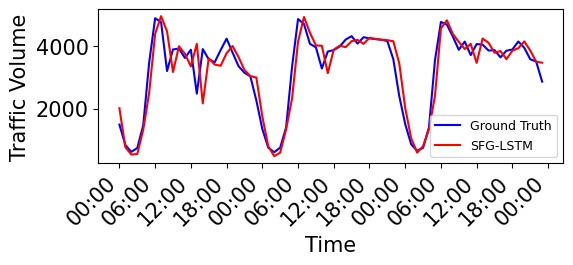

In [64]:
labelX = [0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66, 72]
label = ["00:00", "06:00", "12:00", "18:00", "00:00", "06:00", "12:00", "18:00", "00:00", "06:00", "12:00", "18:00", "00:00"]
fig = plt.figure(figsize=(6, 2))
ax = plt.axes()

plt.plot(realLst, "b", label="Ground Truth")
plt.plot(outLst, "r", label="SFG-LSTM")

plt.legend()
plt.rcParams['font.size'] = 15
plt.legend(fontsize = "9")
plt.xlabel("Time")
plt.ylabel("Traffic Volume")

ax.set_xticks(labelX)
ax.set_xticklabels(label)
plt.xticks(rotation=45, ha='right')
plt.savefig(r"C:\Users\bigti\Box\Research\2024StreetFunction\Figures\result_6_1.png", dpi = 300, bbox_inches='tight')

In [5]:
input_length = 24

net = SFGAT_POI_SVI_LONG(input_length)
best_path = r"C:\\Users\bigti\\research\\StreetFunction\\weights_new_poi_svi_long_24\\best\\best.pt"
net.load_state_dict(torch.load(best_path))
net.eval()

test_trafficPath = r"C:\\Users\bigti\\research\\StreetFunction\\Data\\test\\data"
test_adjPath = r"C:\\Users\\bigti\\research\\StreetFunction\\Data\\test\\adj"
xPath = r"C:\\Users\\bigti\\research\\StreetFunction\\X"
scenePath = r"C:\\Users\\bigti\\research\\StreetFunction\\X\\scene.csv"
columnLst = ['SVIID',
            'StreetWidt', 'Length',  
            'Commercial', 'CulturalFa', 'EducationF','Government', 'HealthServ', 
            'Miscellane', 'PublicSafe', 'Recreation', 'ReligiousI', 'Residentia', 
            'SocialServ', 'Transporta', 'Water',
            'Avg_B01001', 'Avg_B010_1', 'Avg_B010_2', 'Avg_B010_3', 'Avg_B02001',
            'Avg_B020_1', 'Avg_B020_2', 'Avg_B08006', 'Avg_B080_1', 'Avg_B080_2',
            'Avg_B08013', 'Avg_B08124', 'Avg_B15003', 'Avg_B19001', 'Avg_B19013',
            'Avg_B23013', 'Avg_B24011', 'Avg_B240_1', 'Avg_B240_2', 'Avg_B240_3',
            'Avg_B240_4', 'Avg_B240_5', 'Avg_B240_6', 'Avg_B240_7', 'Avg_B240_8',
            'Avg_B240_9', 'Avg_B24_10', 'Avg_B24_11', 'Avg_B24_12', 'Avg_B24_13',
            'Avg_B24_14', 'Avg_B24_15', 'Avg_B24_16', 'Avg_B24_17', 'Avg_B24_18',
            'Avg_B24_20', 'Avg_B24_21', 'Avg_B24_22', 'Avg_B24_23', 'Avg_B24_24']
xLst = []
xLst.append(pd.read_csv(os.path.join(xPath, "Divided_2016.csv"))[columnLst])
xLst.append(pd.read_csv(os.path.join(xPath, "Divided_2017.csv"))[columnLst])
xLst.append(pd.read_csv(os.path.join(xPath, "Divided_2018.csv"))[columnLst])
xLst.append(pd.read_csv(os.path.join(xPath, "Divided_2019.csv"))[columnLst])
# print(os.listdir(test_trafficPath))

testDateLst, testTrafficLst, testAdjLst = getDatasetLst(test_trafficPath, test_adjPath)
test_dataset = NYCTrafficCountDataset_test_long(testTrafficLst, xLst, testAdjLst, testDateLst, scenePath, input_length)
test_dataloader = DataLoader(test_dataset, 
                                batch_size=1, 
                                shuffle=False, 
                                num_workers=5)

TypeError: super(type, obj): obj must be an instance or subtype of type

In [ ]:
outLst = []
realLst = []
roadID = 4

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for i in range(72):
    data = test_dataset[i].to(device)
    mask = data.y[:, 1]
    y = data.y[:, 0]
    y = y[mask==1]

    minv = data.y[:, 2][mask==1]
    maxv = data.y[:, 3][mask==1]    

    net.to(device)
    out = net(data)
    out = out.reshape(out.shape[0])
    out = out[mask==1]
    out = out * (maxv - minv) + minv

    out = out.detach().tolist()[roadID]
    y = y.detach().tolist()[roadID]
    outLst.append(out)
    realLst.append(y)